In [1]:
import numpy as np
from trikde.triangleplot import TrianglePlot
from trikde.pdfs import IndependentLikelihoods, DensitySamples, InterpolatedLikelihood, CustomPriorHyperCube
import pickle
import matplotlib.pyplot as plt
from samana.output_storage import Output
from lenstronomy.Util.param_util import shear_cartesian2polar
from lenstronomy.Util.param_util import ellipticity2phi_q
from copy import deepcopy
from samana.Data.Mocks.mock_1_data import Mock1Data
from samana.Data.Mocks.mock_2_data import Mock2Data
from samana.Data.Mocks.mock_3_data import Mock3Data
from samana.Data.Mocks.mock_4_data import Mock4Data
from samana.Data.Mocks.mock_5_data import Mock5Data
from samana.Data.Mocks.mock_6_data import Mock6Data
from samana.Data.Mocks.mock_7_data import Mock7Data
from samana.Data.Mocks.mock_8_data import Mock8Data
from samana.Data.Mocks.mock_9_data import Mock9Data
from samana.Data.Mocks.mock_10_data import Mock10Data
from samana.Data.Mocks.mock_11_data import Mock11Data
from samana.Data.Mocks.mock_12_data import Mock12Data
from samana.Data.Mocks.mock_13_data import Mock13Data
from samana.Data.Mocks.mock_14_data import Mock14Data
from samana.Data.Mocks.mock_15_data import Mock15Data
from samana.Data.Mocks.mock_16_data import Mock16Data
from samana.Data.Mocks.mock_17_data import Mock17Data
from samana.Data.Mocks.mock_18_data import Mock18Data
from samana.Data.Mocks.mock_19_data import Mock19Data
from samana.Data.Mocks.mock_20_data import Mock20Data
from samana.Data.Mocks.mock_21_data import Mock21Data
from samana.Data.Mocks.mock_22_data import Mock22Data
from samana.Data.Mocks.mock_23_data import Mock23Data
from samana.Data.Mocks.mock_24_data import Mock24Data
from samana.Data.Mocks.mock_25_data import Mock25Data
from samana.Model.Mocks.mock_1_model import Mock1Model
from samana.Model.Mocks.mock_2_model import Mock2Model
from samana.Model.Mocks.mock_3_model import Mock3Model
from samana.Model.Mocks.mock_4_model import Mock4Model
from samana.Model.Mocks.mock_5_model import Mock5Model
from samana.Model.Mocks.mock_6_model import Mock6Model
from samana.Model.Mocks.mock_7_model import Mock7Model
from samana.Model.Mocks.mock_8_model import Mock8Model
from samana.Model.Mocks.mock_9_model import Mock9Model
from samana.Model.Mocks.mock_10_model import Mock10Model
from samana.Model.Mocks.mock_11_model import Mock11Model
from samana.Model.Mocks.mock_12_model import Mock12Model
from samana.Model.Mocks.mock_13_model import Mock13Model
from samana.Model.Mocks.mock_14_model import Mock14Model
from samana.Model.Mocks.mock_15_model import Mock15Model
from samana.Model.Mocks.mock_16_model import Mock16Model
from samana.Model.Mocks.mock_17_model import Mock17Model
from samana.Model.Mocks.mock_18_model import Mock18Model
from samana.Model.Mocks.mock_19_model import Mock19Model
from samana.Model.Mocks.mock_20_model import Mock20Model
from samana.Model.Mocks.mock_21_model import Mock21Model
from samana.Model.Mocks.mock_22_model import Mock22Model
from samana.Model.Mocks.mock_23_model import Mock23Model
from samana.Model.Mocks.mock_24_model import Mock24Model
from samana.Model.Mocks.mock_25_model import Mock25Model
from samana.image_magnification_util import perturbed_fluxes_from_fluxes
from samana.analysis_util import cut_on_data, likelihood_function_change
import os

# performed with samana commit dde303b
 

cosmos_source = True
mock_lens_data_list = [Mock1Data(cosmos_source=cosmos_source), 
                       Mock2Data(cosmos_source=cosmos_source), 
                       Mock3Data(cosmos_source=cosmos_source), 
                       Mock4Data(cosmos_source=cosmos_source), 
                       Mock5Data(cosmos_source=cosmos_source), 
                       Mock6Data(cosmos_source=cosmos_source),
                      Mock7Data(cosmos_source=cosmos_source),
                       Mock8Data(cosmos_source=cosmos_source), 
                       Mock9Data(cosmos_source=cosmos_source), 
                       Mock10Data(cosmos_source=cosmos_source), 
                       Mock11Data(cosmos_source=cosmos_source), 
                       Mock12Data(cosmos_source=cosmos_source),
                      Mock13Data(cosmos_source=cosmos_source), 
                       Mock14Data(cosmos_source=cosmos_source), 
                       Mock15Data(cosmos_source=cosmos_source),
                      Mock16Data(cosmos_source=cosmos_source),
                      Mock17Data(cosmos_source=cosmos_source),
                      Mock18Data(cosmos_source=cosmos_source),
                      Mock19Data(cosmos_source=cosmos_source),
                      Mock20Data(cosmos_source=cosmos_source),
                      Mock21Data(cosmos_source=cosmos_source),
                      Mock22Data(cosmos_source=cosmos_source),
                      Mock23Data(cosmos_source=cosmos_source),
                      Mock24Data(cosmos_source=cosmos_source),
                      Mock25Data(cosmos_source=cosmos_source)]
mock_lens_model_list = [Mock1Model, 
                        Mock2Model, 
                        Mock3Model,
                        Mock4Model, 
                        Mock5Model,
                       Mock6Model,
                       Mock7Model,
                       Mock8Model,
                       Mock9Model,
                       Mock10Model,
                       Mock11Model,
                       Mock12Model,
                       Mock13Model,
                       Mock14Model,
                       Mock15Model,
                       Mock16Model,
                       Mock17Model,
                       Mock18Model,
                       Mock19Model,
                       Mock20Model,
                       Mock21Model,
                       Mock22Model,
                       Mock23Model,
                       Mock24Model,
                       Mock25Model]

#path_to_data = os.getcwd()+'/../notebooks/output_v1/'
path_to_data = os.getcwd()+'/put_data_here/output_classes/'
seed = 1

In [2]:
from lenstronomy.LensModel.lens_model import LensModel
from scipy.optimize import minimize

def flux_ratios(lens_model, x, y, kwargs):
    m = np.absolute(lens_model.magnification(x, y, kwargs))
    fr = m[1:]/m[0]
    return fr

def source_position_penalty(lens_model, x, y, f, kwargs):
    betax, betay = lens_model.ray_shooting(x, y, kwargs)
    dx_source = (
            (betax[0] - betax[1]) ** 2
            + (betax[0] - betax[2]) ** 2
            + (betax[0] - betax[3]) ** 2
            + (betax[1] - betax[2]) ** 2
            + (betax[1] - betax[3]) ** 2
            + (betax[2] - betax[3]) ** 2
        )
    dy_source = (
        (betay[0] - betay[1]) ** 2
        + (betay[0] - betay[2]) ** 2
        + (betay[0] - betay[3]) ** 2
        + (betay[1] - betay[2]) ** 2
        + (betay[1] - betay[3]) ** 2
        + (betay[2] - betay[3]) ** 2
    )
    penalty_source = np.sqrt((dx_source + dy_source) / 0.0001**2)
    return penalty_source
    

def flux_ratio_penalty(lens_model, x, y, f, kwargs):
    f_model = flux_ratios(lens_model, x, y, kwargs)
    penalty_f = (f[0] - f_model[0])**2 + (f[1] - f_model[1])**2 + (f[2] - f_model[2])**2
    penalty_f /= 0.001**2
    return penalty_f ** 0.5

def args_to_kwargs(args_lens):
    kwargs = [{'theta_E': args_lens[0],
                    'center_x': 0.0, 
                    'center_y': 0.0, 
                    'e1': args_lens[1], 
                    'e2': args_lens[2], 
                    'gamma': args_lens[3],
                    'a4_a': args_lens[4], 
                    'a3_a': args_lens[5], 
                    'delta_phi_m3': args_lens[6], 
                    'delta_phi_m4': args_lens[7]}, 
                   {'gamma1': args_lens[8], 
                    'gamma2': args_lens[9]}]
    return kwargs
    
def kwargs_to_args(kwargs):
    return np.array([kwargs[0]['theta_E'], 
                    kwargs[0]['e1'], 
                    kwargs[0]['e2'],
                    kwargs[0]['gamma'],
                    kwargs[0]['a4_a'],
                    kwargs[0]['a3_a'],
                    kwargs[0]['delta_phi_m3'],
                    kwargs[0]['delta_phi_m4'],
                    kwargs[1]['gamma1'],
                    kwargs[1]['gamma2']])
    
def func_to_minimize(args_lens, x, y, f, lens_model):
    
    kwargs_lens = args_to_kwargs(args_lens)
    penalty_source = source_position_penalty(lens_model, x, y, f, kwargs_lens)
    penalty_flux_ratio = flux_ratio_penalty(lens_model, x, y, f, kwargs_lens)
    prior_gamma = np.sqrt((args_lens[3] - 2)**2 / 0.05**2)
    return penalty_source + penalty_flux_ratio + prior_gamma

a3a_fit = []
a4a_fit = []
a3a_phi = []
a4a_phi = []

a3a_true = []
a4a_true = []
a3a_phi_true = []
a4a_phi_true = []

for lens_index in np.arange(1, 26):

    data = mock_lens_data_list[lens_index-1]
    model = mock_lens_model_list[lens_index-1]
    kwargs_init = model(data).setup_lens_model()[-1][0]
    args_init = kwargs_to_args(kwargs_init)
    lens_model = LensModel(['EPL_MULTIPOLE_M3M4', 'SHEAR'])
    args_minimize = (data.x_image, 
                     data.y_image, 
                     data.magnifications[1:]/data.magnifications[0], 
                    lens_model)
    opt = minimize(func_to_minimize, x0=args_init, args=args_minimize, method='Nelder-Mead')
    args_solution = opt['x']
    print('MOCK '+str(lens_index))
    print('solution accuracy: ', func_to_minimize(args_solution, *args_minimize))
    print('flux ratio fit penalty: ', flux_ratio_penalty(lens_model, args_minimize[0], 
                                                         args_minimize[1], 
                                                         args_minimize[2], 
                                                         args_to_kwargs(args_solution)))
    print('source position penalty: ', source_position_penalty(lens_model, args_minimize[0], 
                                                         args_minimize[1], 
                                                         args_minimize[2], 
                                                         args_to_kwargs(args_solution)))
    print('gamma prior penalty: ', np.sqrt((args_solution[3] - 2)**2 / 0.05**2))
    print('\n')
    print('fit flux ratios: ', flux_ratios(lens_model, 
                                           args_minimize[0], 
                                           args_minimize[1], 
                                           args_to_kwargs(args_solution)))
    print('observed flux ratios: ', args_minimize[2])
    print('\n')
    print('\n')
    kwargs_solution = args_to_kwargs(args_solution)
    
    a3a_fit.append(kwargs_solution[0]['a3_a'])
    a4a_fit.append(kwargs_solution[0]['a4_a'])
    a3a_phi.append(kwargs_solution[0]['delta_phi_m3'])
    a4a_phi.append(kwargs_solution[0]['delta_phi_m4'])
    
    a3a_true.append(data.a3a_true)
    a4a_true.append(data.a4a_true)
    a3a_phi_true.append(data.delta_phi_m3_true)
    a4a_phi_true.append(0.0)

a3a_fit = np.array(a3a_fit)
a4a_fit = np.array(a4a_fit)
a3a_phi_fit = np.array(a3a_phi)
a4a_phi_fit = np.array(a4a_phi)

a3a_true = np.array(a3a_true)
a4a_true = np.array(a4a_true)
a3a_phi_true = np.array(a3a_phi_true)
a4a_phi_true = np.array(a4a_phi_true)

MOCK 1
solution accuracy:  211.65099965176097
flux ratio fit penalty:  0.05549110704522559
source position penalty:  200.02125297708596
gamma prior penalty:  11.574255567629786


fit flux ratios:  [2.40516058 1.0253279  1.04103402]
observed flux ratios:  [2.40515315 1.02527299 1.0410311 ]




MOCK 2
solution accuracy:  56.87761235098868
flux ratio fit penalty:  9.833755983326071
source position penalty:  44.87923112244129
gamma prior penalty:  2.1646252452213144


fit flux ratios:  [2.07414915 1.62516054 0.77223518]
observed flux ratios:  [2.07313925 1.63287272 0.76621812]




MOCK 3
solution accuracy:  21.119933122262164
flux ratio fit penalty:  0.10702122084732746
source position penalty:  1.0268524807183284
gamma prior penalty:  19.98605942069651


fit flux ratios:  [2.75707257 1.33817429 1.08989143]
observed flux ratios:  [2.75708802 1.33821047 1.08999096]




MOCK 4
solution accuracy:  49.27173901392068
flux ratio fit penalty:  48.45470906874994
source position penalty:  8.8753425

In [3]:
def get_samples(output, data, kwargs_cut_on_data, param_names_DM, 
                n_bootstrap):

    out, weights = cut_on_data(output, data, **kwargs_cut_on_data)
    for i in range(0, n_bootstrap):
        _out, _weights = cut_on_data(output, data, **kwargs_cut_on_data)
        out = Output.join(out, _out)
        weights = np.append(weights, _weights)
        
    samples = out.parameter_array(param_names_DM)
    return samples, out, weights

In [11]:
np.random.seed(seed)
kwargs_inference = {'ABC_flux_ratio_likelihood': True,
                      'flux_ratio_uncertainty_percentage': [0.03] * 3,
                      'uncertainty_in_flux_ratios': True,
                      'imaging_data_likelihood': False,
                      'imaging_data_hard_cut': True,
                      'imaging_data_likelihood_scale': None,
                      'percentile_cut_image_data': 100,
                      'n_keep_S_statistic': 1000,
                      'perturb_measurements': True,
                      'S_statistic_tolerance': None
                      }

nbins = 25
n_bootstraps = 9
kwargs_density = {'nbins': nbins, 'use_kde': True, 'param_ranges': [[-2.5, -1.0], [4, 10]]}
param_names_DM = ['log10_sigma_sub', 'log_mc']
param_ranges = [[-2.5, -1.0], [4, 10]]
param_names_macro = []

pdf_list = []
pdf_list_weighted = []
pdf_list_weighted_2 = []
pdf_list_weighted_3 = []
pdf_list_weighted_4 = []

index_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
#index_list = [1,2,3,4,5,6,7,8,9,10]
for index_lens in index_list:
    
    print('lens index: ', index_lens)
    output_list = []
    
    with open(path_to_data+'/multipole_test/mock_'+str(index_lens)+'_no_image_data_multipole_test_output', 'rb') as f:
        _out = pickle.load(f)
    f.close()
    
    samples_no_image_data, _out_no_image_data, _ = get_samples(_out, 
                                                     mock_lens_data_list[index_lens-1], 
                                                     kwargs_inference, 
                                                     param_names_DM, n_bootstraps)
    pdf = DensitySamples(samples_no_image_data, param_names_DM, None, **kwargs_density)
    pdf_list.append(pdf)
    
    true_a3, true_a4 = mock_lens_data_list[index_lens-1].a3a_true, mock_lens_data_list[index_lens-1].a4a_true
    true_delta_phi_m3 = mock_lens_data_list[index_lens-1].delta_phi_m3_true
    a4asigma = 0.005
    a3asigma = 0.0025
    phi3_sigma = np.pi/6/4
    phi4_sigma = np.pi/8/4
    a3 = np.squeeze(_out_no_image_data.macromodel_parameter_array(['a3_a']))
    delta_phi_m4 = np.squeeze(_out_no_image_data.macromodel_parameter_array(['delta_phi_m4']))
    delta_phi_m3 = np.squeeze(_out_no_image_data.macromodel_parameter_array(['delta_phi_m3']))
    #print(delta_phi_m4)
    a4 = np.squeeze(_out_no_image_data.macromodel_parameter_array(['a4_a']))
    multipole_weights_a3 = np.exp(-0.5 * (a3 - true_a3)**2 / a3asigma**2)
    multipole_weights_a4 = np.exp(-0.5 * (a4 - true_a4)**2 / a4asigma**2)
    multipole_weights_deltaphi_m3 = np.exp(-0.5 * (delta_phi_m3 - true_delta_phi_m3)**2 / phi3_sigma**2)
    multipole_weights_deltaphi_m4 = np.exp(-0.5 * (delta_phi_m4 - 0.0)**2 / phi4_sigma**2)
    
    pdf_weighted = DensitySamples(samples_no_image_data, param_names_DM, 
                                  multipole_weights_deltaphi_m4, **kwargs_density)
    pdf_list_weighted.append(pdf_weighted)
    
    pdf_weighted = DensitySamples(samples_no_image_data, param_names_DM, 
                                  multipole_weights_a3*multipole_weights_a4, 
                                  **kwargs_density)
    pdf_list_weighted_2.append(pdf_weighted)
    
    a4asigma = 0.005
    a3asigma = 0.0025
    phi3_sigma = np.pi/6/4
    phi4_sigma = np.pi/8/4
    multipole_weights_a3 = np.exp(-0.5 * (a3 - a3a_fit[index_lens-1])**2 / a3asigma**2)
    multipole_weights_a4 = np.exp(-0.5 * (a4 - a4a_fit[index_lens-1])**2 / a4asigma**2)
    multipole_weights_deltaphi_m3 = np.exp(-0.5 * (delta_phi_m3 - a3a_phi_fit[index_lens-1])**2 / phi3_sigma**2)
    multipole_weights_deltaphi_m4 = np.exp(-0.5 * (delta_phi_m4 - a4a_phi_fit[index_lens-1])**2 / phi4_sigma**2)
    
    pdf_weighted = DensitySamples(samples_no_image_data, param_names_DM, 
                                  multipole_weights_deltaphi_m4, 
                                  **kwargs_density)
    pdf_list_weighted_3.append(pdf_weighted)
    
    pdf_weighted = DensitySamples(samples_no_image_data, param_names_DM, 
                                  multipole_weights_a3*multipole_weights_a4,
                                  **kwargs_density)
    pdf_list_weighted_4.append(pdf_weighted)
    
    
    

lens index:  1


/Users/danielgilman/Code/samana/samana/output_storage.py:147: RuntimeWarning: divide by zero encountered in divide
  self._flux_ratios = self.image_magnifications[:, 1:] / self.image_magnifications[:, 0, np.newaxis]
/Users/danielgilman/Code/samana/samana/output_storage.py:147: RuntimeWarning: invalid value encountered in divide
  self._flux_ratios = self.image_magnifications[:, 1:] / self.image_magnifications[:, 0, np.newaxis]
/Users/danielgilman/Code/samana/samana/image_magnification_util.py:20: RuntimeWarning: invalid value encountered in add
  flux_ratios_perturbed[:, i] += np.random.normal(0.0,


lens index:  2
lens index:  3
lens index:  4
lens index:  5
lens index:  6
lens index:  7
lens index:  8
lens index:  9
lens index:  10
lens index:  11
lens index:  12
lens index:  13
lens index:  14
lens index:  15
lens index:  16
lens index:  17
lens index:  18
lens index:  19
lens index:  20
lens index:  21
lens index:  22
lens index:  23
lens index:  24
lens index:  25


/var/folders/8v/kc3z7kcx6nggk5cd5q1_ltfc0000gn/T/ipykernel_55082/2396234246.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


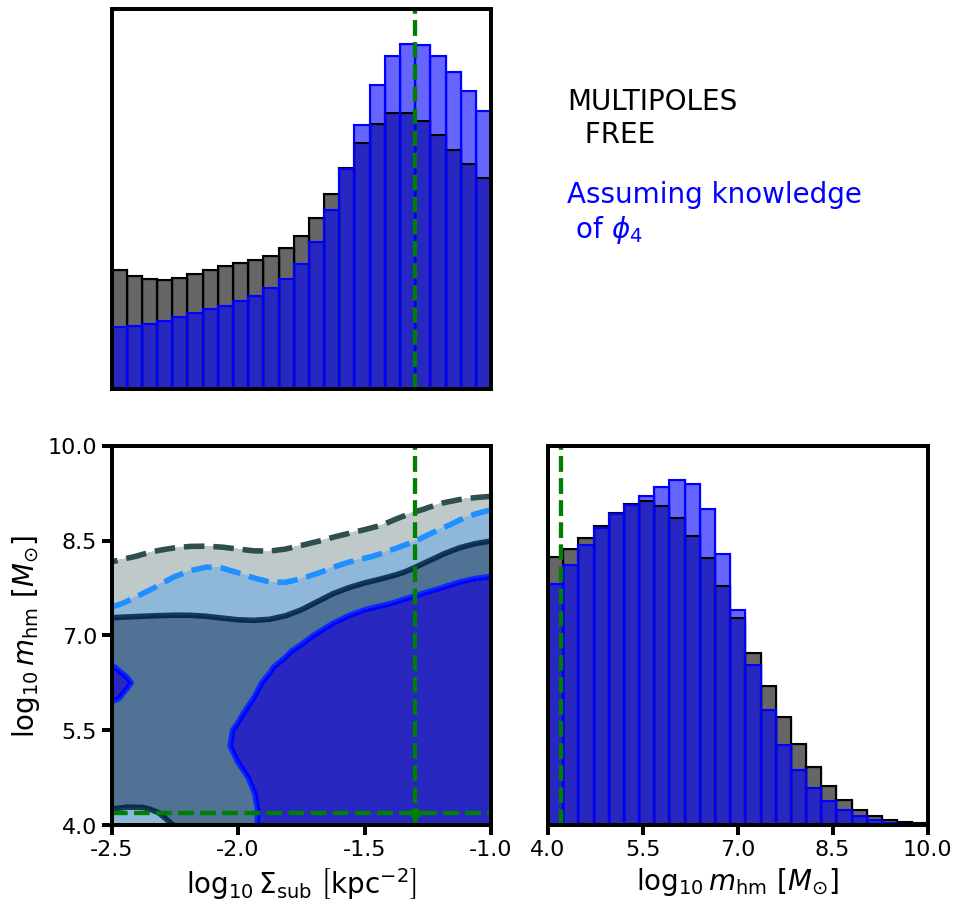

/var/folders/8v/kc3z7kcx6nggk5cd5q1_ltfc0000gn/T/ipykernel_55082/2396234246.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


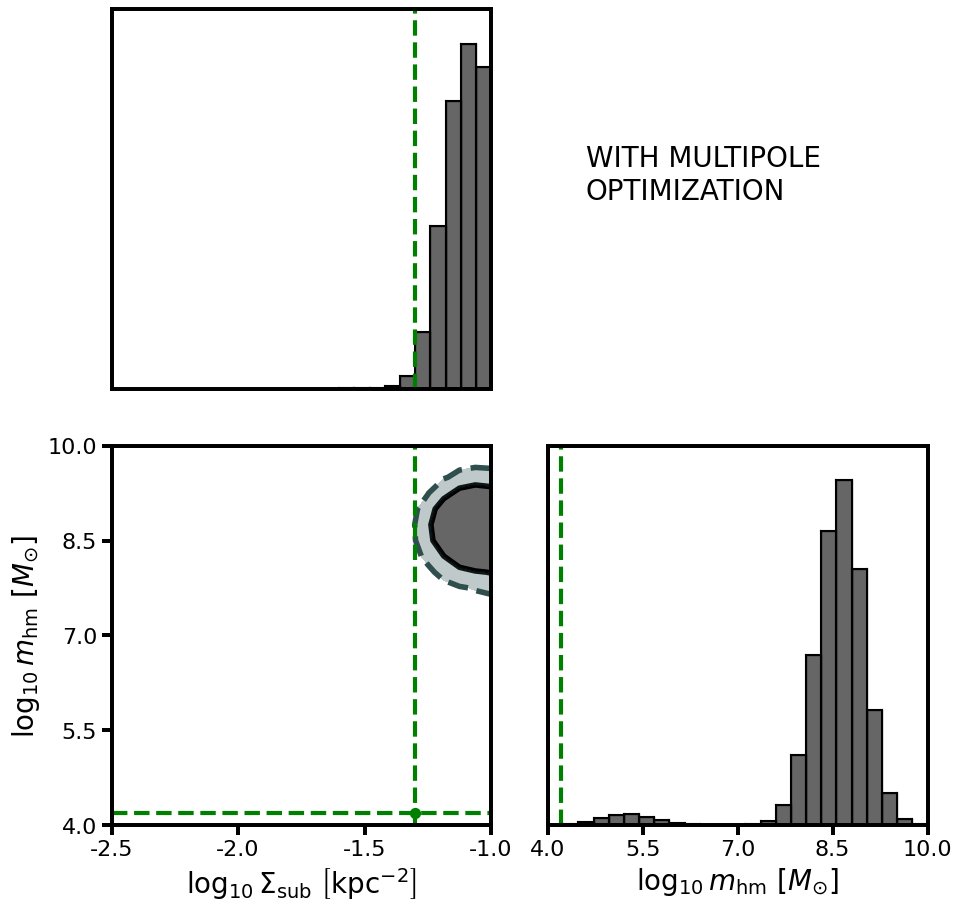

In [19]:
include_lenses = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

_include_pdf_list = []
for index_lens in include_lenses:
    _include_pdf_list.append(pdf_list[index_lens-1])
joint_likelihood_1 = IndependentLikelihoods(_include_pdf_list)

_include_pdf_list = []
for index_lens in include_lenses:
    _include_pdf_list.append(pdf_list_weighted[index_lens-1])
joint_likelihood_2 = IndependentLikelihoods(_include_pdf_list)

triplot = TrianglePlot([joint_likelihood_1, joint_likelihood_2])
truths = {'log10_sigma_sub': np.log10(0.05), 'log_mc': 4.2}
ax = triplot.make_triplot(filled_contours=True,truths=truths,show_intervals=False)

ax[1].annotate('MULTIPOLES\n  FREE',xy=(0.05, 0.65), fontsize=20)
ax[1].annotate('Assuming knowledge\n of '+r'$\phi_4$',xy=(0.05, 0.4), fontsize=20,color='b')
#ax[1].annotate(r'$a_3, \ a_4$'+' knowledge',xy=(0.05, 0.45), fontsize=20,color='m')

xticks = [-2.5, -2.0, -1.5, -1.0]
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xticks, fontsize=16)
ax[2].set_xlabel(r'$\log_{10} \Sigma_{\rm{sub}} \ \left[\rm{kpc^{-2}}\right]$', fontsize=20)
ax[2].set_ylabel(r'$\log_{10} m_{\rm{hm}} \ \left[M_{\odot}\right]$', fontsize=20)
yticks = [4.0, 5.5, 7.0, 8.5, 10.0]
ax[2].set_yticks(yticks)
ax[2].set_yticklabels(yticks, fontsize=16)
ax[3].set_xticks(yticks)
ax[3].set_xticklabels(yticks, fontsize=16)
ax[3].set_xlabel(r'$\log_{10} m_{\rm{hm}} \ \left[M_{\odot}\right]$', fontsize=20)
plt.tight_layout()
plt.savefig('multipole_inference_test.pdf')
plt.show()


_include_pdf_list = []
for index_lens in include_lenses:
    _include_pdf_list.append(pdf_list_weighted_3[index_lens-1])
joint_likelihood_3 = IndependentLikelihoods(_include_pdf_list)

_include_pdf_list = []
for index_lens in include_lenses:
    _include_pdf_list.append(pdf_list_weighted_4[index_lens-1])
joint_likelihood_4 = IndependentLikelihoods(_include_pdf_list)

triplot = TrianglePlot([joint_likelihood_4])
truths = {'log10_sigma_sub': np.log10(0.05), 'log_mc': 4.2}
ax = triplot.make_triplot(filled_contours=True,truths=truths,show_intervals=False)
ax[1].annotate('WITH MULTIPOLE\nOPTIMIZATION',xy=(0.1, 0.5), fontsize=20)
xticks = [-2.5, -2.0, -1.5, -1.0]
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xticks, fontsize=16)
ax[2].set_xlabel(r'$\log_{10} \Sigma_{\rm{sub}} \ \left[\rm{kpc^{-2}}\right]$', fontsize=20)
ax[2].set_ylabel(r'$\log_{10} m_{\rm{hm}} \ \left[M_{\odot}\right]$', fontsize=20)
yticks = [4.0, 5.5, 7.0, 8.5, 10.0]
ax[2].set_yticks(yticks)
ax[2].set_yticklabels(yticks, fontsize=16)
ax[3].set_xticks(yticks)
ax[3].set_xticklabels(yticks, fontsize=16)
ax[3].set_xlabel(r'$\log_{10} m_{\rm{hm}} \ \left[M_{\odot}\right]$', fontsize=20)
plt.tight_layout()
#plt.savefig('multipole_inference_test_badprior.pdf')
plt.show()

